# NYC Air Quality Analysis

This notebook walks through data analysis using the air quality dataset from Open Data NYC and data from the American Community Survey (ACS). 
This is a cleaned up version of some messier EDA of these datasets. In this notebook, I'd like to present the following:
* Description of the air quality dataset; also divided up by air quality type and geography
* Matching up geographies with other variables from the ACS, such as median income, age, and race
* Some visualizations and maps showing the data in the air quality dataset and/or the ACS datasets.

Provide some written analysis of the individual datasets and the merged dataset to ask questions and draw preliminary conclusions about the relationship between air quality and certain socioeconomic factors.

In [1]:
# load in packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from extract import handle_nyc_open_data, load_and_merge_geo_data
import constants as const

# Air Quality Dataset

## Initial analysis + wrangling

In [2]:
# load in raw data
air_quality_df = handle_nyc_open_data(const.AIR_QUALITY_API_ENDPOINT)
air_quality_df["start_date"] = pd.DatetimeIndex(air_quality_df["start_date"])

# take a look at the raw data
display(air_quality_df.head())
display(air_quality_df.info())
print(air_quality_df["time_period"].unique())
print(air_quality_df["measure"].unique())

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01,12.0
1,823492,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,307.0,Sunset Park (CD7),Summer 2022,2022-06-01,6.7
2,827012,386,Ozone (O3),Mean,ppb,CD,313.0,Coney Island (CD13),Summer 2022,2022-06-01,37.7
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01,31.7
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8


<class 'pandas.core.frame.DataFrame'>
Index: 18025 entries, 0 to 24
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unique_id       18025 non-null  int64         
 1   indicator_id    18025 non-null  int64         
 2   name            18025 non-null  object        
 3   measure         18025 non-null  object        
 4   measure_info    18025 non-null  object        
 5   geo_type_name   18025 non-null  object        
 6   geo_join_id     18016 non-null  float64       
 7   geo_place_name  18016 non-null  object        
 8   time_period     18025 non-null  object        
 9   start_date      18025 non-null  datetime64[ns]
 10  data_value      18025 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 1.7+ MB


None

['Summer 2022' 'Annual Average 2022' 'Winter 2021-22' 'Summer 2021'
 'Annual Average 2021' 'Winter 2020-21' 'Summer 2020'
 'Annual Average 2020' 'Winter 2019-20' 'Summer 2019'
 'Annual Average 2019' '2019' 'Winter 2018-19' 'Summer 2018'
 'Annual Average 2018' 'Winter 2017-18' 'Summer 2017' '2017-2019'
 'Annual Average 2017' 'Winter 2016-17' 'Summer 2016'
 'Annual Average 2016' 'Winter 2015-16' 'Summer 2015' '2015-2017'
 'Annual Average 2015' '2015' 'Winter 2014-15' 'Summer 2014' '2014'
 'Winter 2013-14' 'Annual Average 2014' 'Summer 2013' '2013'
 'Winter 2012-13' 'Annual Average 2013' 'Summer 2012' '2012-2014'
 'Winter 2011-12' 'Annual Average 2012' 'Summer 2011' '2011'
 'Winter 2010-11' 'Annual Average 2011' 'Summer 2010' '2010'
 'Annual Average 2010' 'Winter 2009-10' '2-Year Summer Average 2009-2010'
 'Summer 2009' '2009-2011' 'Winter 2008-09' 'Annual Average 2009'
 '2005-2007' '2005']
['Mean' 'Million miles' 'Estimated annual rate (under age 18)'
 'Estimated annual rate' 'Estimated 

We can see in the raw data that we have a variety of metrics, units, time period, places, and geospatial granularities. We also have some null values in the columns `geo_join_id` and `geo_place_name`. Let's first take a look at those null values and see if we can remove from our dataframe.

Next, we want to look at the different names, measure, measure_info, and time periods to see if we separate into multiple dfs and perhaps standardize a bit.

In [3]:
display(air_quality_df[pd.isna(air_quality_df["geo_join_id"]) | pd.isna(air_quality_df["geo_place_name"])])
print(air_quality_df["geo_type_name"].unique())

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
72,828009,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,10.0
73,828010,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,14.0
90,827818,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,60.0
94,827821,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,145.0
95,827819,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,74.0
99,828011,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,15.0
100,827817,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,43.0
102,827820,653,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,92.0
110,828012,655,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children",Borough,NaN,NaN,2017-2019,2017-01-01,27.0


['UHF34' 'CD' 'UHF42' 'Borough' 'Citywide']


Here we can see that there are 9 entries with null geography, but the `geo_type_name` is "Borough". For the purposes of this analyis, I'm most interested in a higher geospatial granularity than borough as a whole. Given this, we can drop these observations with null geographies. Additionally, let's take a look at all the different `geo_type_name` entries and restrict to only sub-borough geographies.

Doing a little poking around, we have UHF (United Hospital Fund) geographies [UHF34](https://www.nyc.gov/assets/doh/downloads/pdf/tracking/uhf34.pdf) and [UHF42](https://www.nyc.gov/assets/doh/downloads/pdf/tracking/uhf42.pdf). We also have [community district (CD)](https://www.nyc.gov/assets/planning/download/pdf/data-maps/maps-geography/political-boundaries/community-district-20180924.pdf) specifications. These are all at a sub-borough granularity. Let's remove all the entries that are "Borough" and "Citywide". We can handle the overlap of these geographies later on.

In [4]:
air_quality_subborough_df = air_quality_df[~air_quality_df["geo_type_name"].isin(["Borough", "Citywide"])]
display(air_quality_subborough_df.head())
print(f"Number of sub-borough entries: {air_quality_subborough_df.shape[0]}")

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01,12.0
1,823492,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,307.0,Sunset Park (CD7),Summer 2022,2022-06-01,6.7
2,827012,386,Ozone (O3),Mean,ppb,CD,313.0,Coney Island (CD13),Summer 2022,2022-06-01,37.7
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01,31.7
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8


Number of sub-borough entries: 16999


Next, let's take a look at the different names, measures, and measure info.

In [5]:
unique_names_measures_df = air_quality_subborough_df[["name", "measure", "measure_info"]].drop_duplicates()
display(unique_names_measures_df)

,name,measure,measure_info
0,Nitrogen dioxide (NO2),Mean,ppb
1,Fine particles (PM 2.5),Mean,mcg/m3
2,Ozone (O3),Mean,ppb
385,Annual vehicle miles traveled,Million miles,per square mile
410,Annual vehicle miles traveled (trucks),Million miles,per square mile
439,Annual vehicle miles traveled (cars),Million miles,per square mile
679,Asthma emergency departments visits due to Ozone,Estimated annual rate (under age 18),"per 100,000 children"
684,Asthma hospitalizations due to Ozone,Estimated annual rate (under age 18),"per 100,000 children"
686,Cardiac and respiratory deaths due to Ozone,Estimated annual rate,"per 100,000"
691,Asthma emergency departments visits due to Ozone,Estimated annual rate (age 18+),"per 100,000 adults"


Alright, it looks like for each name/type of measurement we have a single combination of "measure" and "measure_info" (e.g. not two different measurements for Nitrogen dioxide (NO2)). Looking at the list of names, I will break down the dataframe into a few different dataframes so the values can be compared:
* Concentration of a given substance in the air (NO2, PM 2.5, O3, Outdoor Air Toxics - Formaldehyde, and Outdoor Air Toxics - Benzene)
* Boiler Emissions
* Health outcomes, hospitalization, respitory issues due to air quality

I'm going to ignore the category of observations having to do with annual vehicle miles traveled since it has less to do with the purpose of this analysis.

In [6]:
particle_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[0:2]["name"]) + list(unique_names_measures_df.loc[753:755]["name"]))]
print(f"Particle dataframe is of size: {particle_df.shape}")
boiler_emissions_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[161:239]["name"]))]
print(f"Boiler emissions dataframe is of size: {boiler_emissions_df.shape}")
health_outcomes_df = air_quality_subborough_df[air_quality_subborough_df["name"].isin(list(unique_names_measures_df.loc[679:734]["name"]))]
print(f"Health outcomes dataframe is of size: {health_outcomes_df.shape}")

Particle dataframe is of size: (13743, 11)
Boiler emissions dataframe is of size: (251, 11)
Health outcomes dataframe is of size: (2096, 11)


Now for each of these individual datasets, let's take a look at the times and time periods the observations were collected. It seems like we'll probably need to do some standardization or temporal aggregation.

In [9]:
particle_df

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,825967,375,Nitrogen dioxide (NO2),Mean,ppb,UHF34,104.0,Pelham - Throgs Neck,Summer 2022,2022-06-01,12.0
1,823492,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,307.0,Sunset Park (CD7),Summer 2022,2022-06-01,6.7
2,827012,386,Ozone (O3),Mean,ppb,CD,313.0,Coney Island (CD13),Summer 2022,2022-06-01,37.7
3,827081,386,Ozone (O3),Mean,ppb,UHF34,103.0,Fordham - Bronx Pk,Summer 2022,2022-06-01,31.7
4,827103,386,Ozone (O3),Mean,ppb,UHF42,503.0,Willowbrook,Summer 2022,2022-06-01,34.8
...,...,...,...,...,...,...,...,...,...,...,...
958,130698,646,Outdoor Air Toxics - Benzene,Annual average concentration,Âµg/m3,UHF42,207.0,East Flatbush - Flatbush,2005,2005-01-01,2.3
962,130768,647,Outdoor Air Toxics - Formaldehyde,Annual average concentration,Âµg/m3,UHF42,408.0,Jamaica,2005,2005-01-01,2.4
2,130772,647,Outdoor Air Toxics - Formaldehyde,Annual average concentration,Âµg/m3,UHF42,502.0,Stapleton - St. George,2005,2005-01-01,2.3
14,130771,647,Outdoor Air Toxics - Formaldehyde,Annual average concentration,Âµg/m3,UHF42,501.0,Port Richmond,2005,2005-01-01,2.4


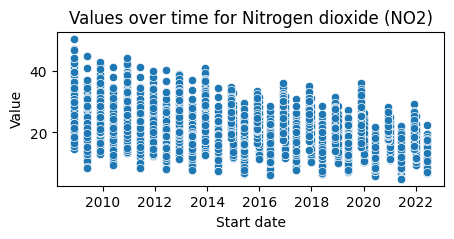

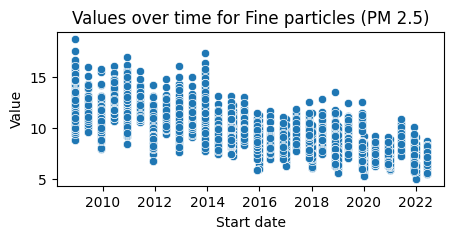

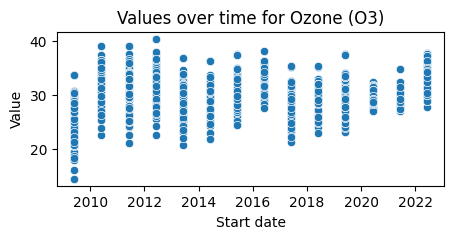

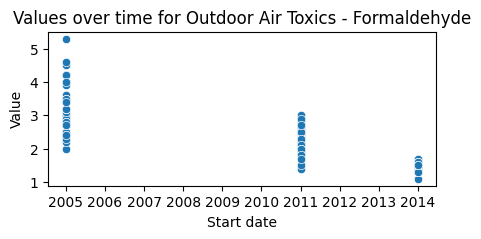

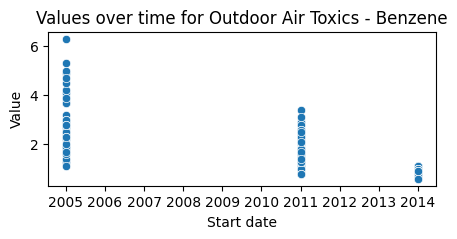

In [12]:
for name in particle_df["name"].unique():
    this_particle_df = particle_df.query("name == @name")
    fig, ax = plt.subplots(figsize=(5, 2))
    sns.scatterplot(data=this_particle_df, x="start_date", y="data_value", ax=ax)
    plt.title(f"Values over time for {name}")
    plt.xlabel("Start date")
    plt.ylabel("Value")
    plt.show()

We only have data on outdoor air toxins in 2005, 2011, and 2014. Let's just remove these entries from our dataset, because they are few and out of date!

For NO2, O3, and PM 2.5 

# Geography Dataset

In [8]:
raw_geo_df = load_and_merge_geo_data()
raw_geo_df

,geo_join_id,geometry,geo_type_name
0,0.0,"MULTIPOLYGON (((1033048.157 181084.379, 103304...",UHF34
1,101.0,"POLYGON ((1017992.894 269222.964, 1017812.000 ...",UHF34
2,102.0,"POLYGON ((1025012.990 270794.260, 1025061.481 ...",UHF34
3,103.0,"POLYGON ((1023994.480 261065.967, 1023885.806 ...",UHF34
4,104.0,"MULTIPOLYGON (((1035076.590 252950.826, 103518...",UHF34
...,...,...,...
66,108.0,"MULTIPOLYGON (((1000370.939 219466.661, 100015...",CD
67,401.0,"MULTIPOLYGON (((1010148.119 227175.052, 101124...",CD
68,480.0,"POLYGON ((1022276.970 218625.343, 1022251.388 ...",CD
69,110.0,"POLYGON ((1002388.021 243854.511, 1002383.991 ...",CD
